In [1]:
import numpy as np, basic, cosmology, local, tools_multitracer as mass, camb, plottools as pl
from matplotlib.pyplot import *
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
cr = rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
zmin, zmax = 0.0001, 50.
zn  = 5000
zi  = np.linspace(zmin,zmax,zn)
dz  = zi[1]-zi[0]
Hzi = basic.cosmofuncs.hubble(zi,divc=True,**local.cps)
rzi = basic.cosmofuncs.dist_comoving(zi,**local.cps)

In [3]:
nu = 353.

In [4]:
zbn  = {'euc':5,'lss':6}
bias = {'euc':np.sqrt(1.+zi),'lss':1+.84*zi}

In [5]:
zbin, dndzi, pz, frac = mass.galaxy_distribution(zi,zbn=zbn)

In [6]:
w = {}

In [7]:
w['W1'] = cosmology.window_cib(rzi,zi,nu)/Hzi

In [8]:
N = 2
for s in ['euc','lss']:
    for zid in range(zbn[s]):
        w['W'+str(N)] = dndzi[s]*pz[s][zid]
        N += 1

In [9]:
lmax = 2048
l =  np.arange(0, lmax+1)

In [10]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=local.H0, ombh2=local.ombh2, omch2=local.omch2)
pars.InitPower.set_params(As=local.As, ns=local.ns)
pars.set_for_lmax(lmax, lens_potential_accuracy=5)
pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
tracers = [ SplinedSourceWindow( z=zi, W=w['W1'], dlog10Ndm=.4, bias=np.sum(w['W1']*dz) ) ]
for I, m in enumerate(list(w)): # add galaxies\n",
    if I==0:  continue
    if I >= 1 and I < zbn['euc']+1: s = 'euc'
    if I >= zbn['euc']+1 and I < zbn['euc']+zbn['lss']+1: s = 'lss'
    tracers += [ SplinedSourceWindow( z=zi, W=w[m], dlog10Ndm=.0, bias_z=bias[s] ) ]
pars.SourceWindows = tracers

[1.00005    1.0050383  1.01000196 ... 7.14002773 7.14072812 7.14142843]
[1.00005    1.0050383  1.01000196 ... 7.14002773 7.14072812 7.14142843]
[1.00005    1.0050383  1.01000196 ... 7.14002773 7.14072812 7.14142843]
[1.00005    1.0050383  1.01000196 ... 7.14002773 7.14072812 7.14142843]
[1.00005    1.0050383  1.01000196 ... 7.14002773 7.14072812 7.14142843]
[ 1.000084    1.00848566  1.01688733 ... 42.98319667 42.99159834
 43.        ]
[ 1.000084    1.00848566  1.01688733 ... 42.98319667 42.99159834
 43.        ]
[ 1.000084    1.00848566  1.01688733 ... 42.98319667 42.99159834
 43.        ]
[ 1.000084    1.00848566  1.01688733 ... 42.98319667 42.99159834
 43.        ]
[ 1.000084    1.00848566  1.01688733 ... 42.98319667 42.99159834
 43.        ]
[ 1.000084    1.00848566  1.01688733 ... 42.98319667 42.99159834
 43.        ]


In [12]:
pars.SourceTerms.counts_redshift = False 
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False

In [13]:
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

In [14]:
klist = mass.tracer_list(add_euc=zbn['euc'], add_lss=zbn['lss'])

In [15]:
camb_list = np.concatenate((np.array(['P']),np.array(['P']),np.array(list(w))))

In [16]:
camb_cls = {}
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if J<I: continue
        if m0 == 'P' and m1 == 'P':
            fac   = 2*np.pi/4.
        elif m0 == 'P' and m1 != 'P':
            fac   = 2*np.pi/np.sqrt((l+1e-30)*(l+1))/2.
        else:
            fac   = 2*np.pi/(l+1e-30)/(l+1)
        camb_cls[m0+m1] = cls[m0+'x'+m1][:lmax+1]*fac

In [22]:
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if J<I: continue
        fspec = mass.tracer_filename(klist[I],klist[J])
        np.savetxt(fspec,np.array((l,camb_cls[m0+m1])))

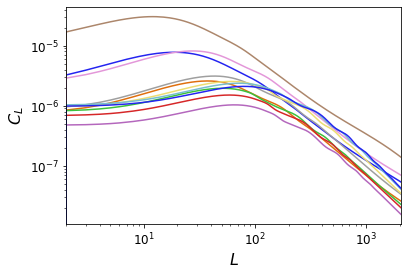

In [23]:
pl.plot_1dstyle(xlog=True,ylog=True,xmin=2,xmax=lmax)
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if I>J: continue
        if not m0==m1: continue
        if m0 in ['P','W1']: continue
        plot(l,camb_cls[m0+m1][:lmax+1],label=m0+m1)